In [106]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import seaborn as sns
from pyspark.sql import functions as F

In [107]:
# Initialize Spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [108]:
# # Read the Parquet file into a Spark DataFrame
# prop_data_df = spark.read.parquet("../data/curated/prop_data_cleaned.parquet")

prop_data_df = spark.read.parquet("../data/curated/prop_data_cleaned.parquet")



In [109]:
# Show the first few rows to understand what the data looks like
prop_data_df.show(truncate=False)

+-----------+---------------------------------------------------+-------------------------------------------------------------------------------------+----+-----+--------+----+------------------+----------+----------------+-----------+--------------+--------+-------+-------+------------+---+---------+--------------+------------------+------------+----------------+--------------+--------------------+-------------+-------------+-------+-----+----------------+------------+----------------+------------+---------------+-----------+--------------------------------+-----------------------------------+---------------------------+-------------+----------------------------------+-------------------------------------+-----------------------------+------------------+---------------------------------------+------------------------------------------+----------------------------------+---------------+------------------------------------+---------------------------------------+------------------------

In [110]:
# Print the schema to see the column names and types
prop_data_df.printSchema()

root
 |-- postal_code: string (nullable = true)
 |-- name: string (nullable = true)
 |-- property_url: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- parkings: integer (nullable = true)
 |-- cost: integer (nullable = true)
 |-- built_in_wardrobes: integer (nullable = true)
 |-- dishwasher: integer (nullable = true)
 |-- air_conditioning: integer (nullable = true)
 |-- floorboards: integer (nullable = true)
 |-- secure_parking: integer (nullable = true)
 |-- intercom: integer (nullable = true)
 |-- heating: integer (nullable = true)
 |-- ensuite: integer (nullable = true)
 |-- balcony_deck: integer (nullable = true)
 |-- gym: integer (nullable = true)
 |-- furnished: integer (nullable = true)
 |-- close_to_shops: integer (nullable = true)
 |-- close_to_transport: integer (nullable = true)
 |-- fully_fenced: integer (nullable = true)
 |-- close_to_schools: integer (nullable = true)
 |-- ducted_heating: integer (nullable = true)
 |

In [111]:
prop_data_df = prop_data_df.drop("unit_floor", "street", "suburb", "state")

prop_data_df = prop_data_df.withColumn("postal_code", col("postal_code").cast("int"))

prop_data_df.printSchema()

root
 |-- postal_code: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- property_url: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- parkings: integer (nullable = true)
 |-- cost: integer (nullable = true)
 |-- built_in_wardrobes: integer (nullable = true)
 |-- dishwasher: integer (nullable = true)
 |-- air_conditioning: integer (nullable = true)
 |-- floorboards: integer (nullable = true)
 |-- secure_parking: integer (nullable = true)
 |-- intercom: integer (nullable = true)
 |-- heating: integer (nullable = true)
 |-- ensuite: integer (nullable = true)
 |-- balcony_deck: integer (nullable = true)
 |-- gym: integer (nullable = true)
 |-- furnished: integer (nullable = true)
 |-- close_to_shops: integer (nullable = true)
 |-- close_to_transport: integer (nullable = true)
 |-- fully_fenced: integer (nullable = true)
 |-- close_to_schools: integer (nullable = true)
 |-- ducted_heating: integer (nullable = true)
 

## OUTLIER ANALYSIS

In [112]:
prop_data_df.describe()

summary,postal_code,name,property_url,beds,baths,parkings,cost,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_Average Travel Time (Mins),parks_Average Travel Distance (Kms),parks_Time_Distance_Product,schools_count,schools_Average Travel Time (Mins),schools_Average Travel Distance (Kms),schools_Time_Distance_Product,supermarkets_count,supermarkets_Average Travel Time (Mins),supermarkets_Average Travel Distance (Kms),supermarkets_Time_Distance_Product,hospitals_count,hospitals_Average Travel Time (Mins),hospitals_Average Travel Distance (Kms),hospitals_Time_Distance_Product,shopping_districts_count,shopping_districts_Average Travel Time (Mins),shopping_districts_Average Travel Distance (Kms),shopping_districts_Time_Distance_Product,CBD_Average Travel Distance (Kms),train_stations_count,train_stations_Average Travel Time (Mins),train_stations_Average Travel Distance (Kms),train_stations_Time_Distance_Product,median_inc,2022_pop,2023_pop,pop_percentage_increase,normalized_livability_score
count,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987,987
mean,3002.436676798379,NULL,NULL,1.707193515704154,1.3100303951367782,1.055724417426545,701.9371833839919,0.475177304964539,0.39209726443769,0.3718338399189463,0.16312056737588654,0.16312056737588654,0.40425531914893614,0.0972644376899696,0.06180344478216818,0.19250253292806485,0.3383991894630192,0.23100303951367782,0.07396149949341439,0.07396149949341439,0.008105369807497468,0.05065856129685917,0.03242147922998987,0.06484295845997974,0.270516717325228,0.028368794326241134,0.10233029381965553,0.07598784194528875,0.02634245187436677,0.04559270516717325,0.0729483282674772,0.07193515704154002,0.1094224924012158,14.998986828774063,6.785271867612251,4.67696724079702,51.06371645277454,3.713272543059777,5.88887506633859,4.390125392000758,50.441578606167624,16.514690982776088,2.8071895178460733,1.1732632272140917,4.624650996588515,1.1458966565349544,4.987801189270003,1.7012502894775263,8.775293939342808,6.391084093211753,3.8029858156028262,1.6921359338061417,8.832237670972628,1.7664235055724424,2.0536980749746707,6.295390070922003,3.7310283687942993,34.616016160080754,43523.916192259225,11666.574803180136,13123.028833403258,11.105428541193584,69.80445795339412
stddev,2.5779515076042743,NULL,NULL,1.6966674548572283,0.541512698957276,0.2624876255975233,577.6992048667028,0.4996366265516552,0.4884657009833284,0.4835393730649064,0.3696629524722615,0.36966295247226133,0.4909961390680077,0.29646773454890973,0.24092028987470965,0.39446541063352514,0.4734049451673226,0.42168803417359885,0.2618409054632491,0.2618409054632491,0.08970967960113312,0.2194106802035405,0.17720649723389675,0.24637339251245183,0.4444519797987431,0.16610828159934615,0.3032358288106093,0.26511299564629237,0.160232767586991,0.20870587499901552,0.2601835059325877,0.25851150579980586,0.48734738685803103,13.900070737880503,4.667682197390368,4.162923689300823,55.217128082200134,1.78222464216435,5.289109107412722,4.934255555172371,98.78797624614532,7.542075148551581,1.3067811681820654,1.053715802733141,13.67911686358834,2.6447910613263916,1.2444917930504331,0.33429938436228945,3.0936006811211687,4.010260868230129,2.051792651037188,1.1860969383967106,11.606065809560654,1.0869224819271766,1.6163948322041894,3.5110574499224425,3.203897218168824,42.60913206319993,16713.890403126483,4899.016263653998,5788.996771855274,4.183918765075411,23.532836244898615
min,3000,1 freshwater plac...,https://www.domai...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [113]:
# Define the columns to calculate percentiles for
columns = ["beds", "baths", "parkings", "cost"]

# Define the percentiles to calculate
percentiles = [0.01, 0.05, 0.1, 0.2, 0.9, 0.95, 0.97, 0.99, 0.995, 0.999]

# Calculate percentiles for each column
percentile_values = {col: prop_data_df.approxQuantile(col, percentiles, 0.001) for col in columns}

# Prepare data for DataFrame creation
rows = []
for col, values in percentile_values.items():
    data = {f"{(p*100)} th_percentile": val for p, val in zip(percentiles, values)}
    row = Row(column=col, **data)
    rows.append(row)

# Create DataFrame from the list of Row objects
percentile_df = spark.createDataFrame(rows)

# Show the DataFrame
percentile_df

column,1.0 th_percentile,5.0 th_percentile,10.0 th_percentile,20.0 th_percentile,90.0 th_percentile,95.0 th_percentile,97.0 th_percentile,99.0 th_percentile,99.5 th_percentile,99.9 th_percentile
beds,0.0,1.0,1.0,1.0,2.0,3.0,3.0,3.0,3.0,50.0
baths,0.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,5.0
parkings,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,5.0
cost,1.0,340.0,470.0,520.0,925.0,1150.0,1300.0,1841.0,2300.0,12500.0


In [114]:
# Define the 99.5th percentile thresholds for each column
upper_limits = {
    "beds": 5,       # 99.5th percentile for beds
    "parkings": 4,   # 99.5th percentile for parkings
    "cost": 800     # 99.5th percentile for cost (assuming cost values are in thousands or as applicable)
}

In [115]:
prop_data_df.printSchema()

root
 |-- postal_code: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- property_url: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- parkings: integer (nullable = true)
 |-- cost: integer (nullable = true)
 |-- built_in_wardrobes: integer (nullable = true)
 |-- dishwasher: integer (nullable = true)
 |-- air_conditioning: integer (nullable = true)
 |-- floorboards: integer (nullable = true)
 |-- secure_parking: integer (nullable = true)
 |-- intercom: integer (nullable = true)
 |-- heating: integer (nullable = true)
 |-- ensuite: integer (nullable = true)
 |-- balcony_deck: integer (nullable = true)
 |-- gym: integer (nullable = true)
 |-- furnished: integer (nullable = true)
 |-- close_to_shops: integer (nullable = true)
 |-- close_to_transport: integer (nullable = true)
 |-- fully_fenced: integer (nullable = true)
 |-- close_to_schools: integer (nullable = true)
 |-- ducted_heating: integer (nullable = true)
 

In [116]:
from pyspark.sql.functions import col

In [117]:
# Filter the DataFrame to keep only entries within the 99.5th percentile
prop_data_df = prop_data_df.filter(
    (col("beds") <= upper_limits["beds"]) &
    (col("parkings") <= upper_limits["parkings"]) &
    (col("cost") <= upper_limits["cost"])
)

# Show some entries to verify the filter
prop_data_df.count()

810

In [118]:
prop_data_df.write.parquet("../data/curated/prop_data_cleaned2.parquet", mode="overwrite")

## DISTRIBUTIONS

In [119]:
sns.set(style="whitegrid")

In [121]:
# columns_of_interest = ['beds', 'baths', 'parkings', 'cost', 'prop_type_index', 'parks',
#                        'schools', 'supermarkets', 'hospitals', 'shopping_districts', 'CBD',
#                        'train_stations']
columns_of_interest = [
    "beds",
    "baths",
    "parkings",
    "cost",
    "prop_type_index",
    "parks_count",
    "parks_Time_Distance_Product",
    "schools_count",
    "schools_Time_Distance_Product",
    "supermarkets_count",
    "supermarkets_Time_Distance_Product",
    "hospitals_count",
    "hospitals_Time_Distance_Product",
    "shopping_districts_count",
    "shopping_districts_Time_Distance_Product",
    "CBD_Average Travel Distance (Kms)",
    "train_stations_count",
    "train_stations_Time_Distance_Product",
    "median_inc",
    "2023_pop",
    "pop_percentage_increase",
    "normalized_livability_score"
]

# Convert Spark DataFrame to Pandas, selecting only the columns of interest
pandas_df = prop_data_df.select(*columns_of_interest).toPandas()

In [122]:
# Define the number of subplots based on the DataFrame's number of columns
pandas_df.columns

Index(['beds', 'baths', 'parkings', 'cost', 'prop_type_index', 'parks_count',
       'parks_Time_Distance_Product', 'schools_count',
       'schools_Time_Distance_Product', 'supermarkets_count',
       'supermarkets_Time_Distance_Product', 'hospitals_count',
       'hospitals_Time_Distance_Product', 'shopping_districts_count',
       'shopping_districts_Time_Distance_Product',
       'CBD_Average Travel Distance (Kms)', 'train_stations_count',
       'train_stations_Time_Distance_Product', 'median_inc', '2023_pop',
       'pop_percentage_increase', 'normalized_livability_score'],
      dtype='object')

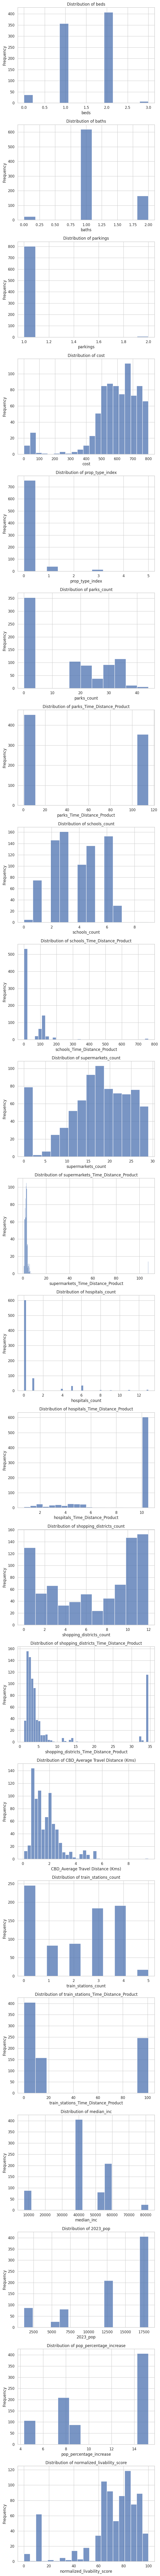

In [123]:
# Define the number of subplots based on the selected columns
fig, axes = plt.subplots(nrows=len(columns_of_interest), ncols=1, figsize=(7, 5 * len(columns_of_interest)))

# Check if only one subplot (axes can be a single AxesSubplot object instead of an array when only one plot)
if len(columns_of_interest) == 1:
    axes = [axes]

# Iterate through each column and create a histogram
for ax, column in zip(axes, columns_of_interest):
    sns.histplot(pandas_df[column], kde=False, ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Central Tendency and Spread

The histogram shows a **unimodal distribution** with a peak around **200-300 units** of cost (assuming this might be in thousands or as per your specific measurement unit). The data is **right-skewed**, indicating that most properties are clustered at the lower end of the cost spectrum, with fewer properties having a higher cost.

### High Frequency of Lower Costs

There's a significant frequency of properties costing between **100 and 400 units**, which might represent the more affordable segment of the market.

### Long Tail to the Right

The long tail extending towards the higher cost values (over **500 units**) suggests the presence of **high-end properties** that are less frequent but significantly more expensive than the typical properties in the dataset. This tail includes some properties that approach **2000 units** in cost, representing the **luxury market segment**.

### Potential Outliers

Properties with costs approaching **2000 units** could be considered **outliers** compared to the majority of the data, or they might represent a distinct segment of the market (e.g., **luxury real estate**).

In [124]:
df_prop = prop_data_df.toPandas()

df_prop = df_prop.select_dtypes(exclude=['object'])

In [125]:
correlation_matrix = df_prop.corr()  # Compute the correlation matrix

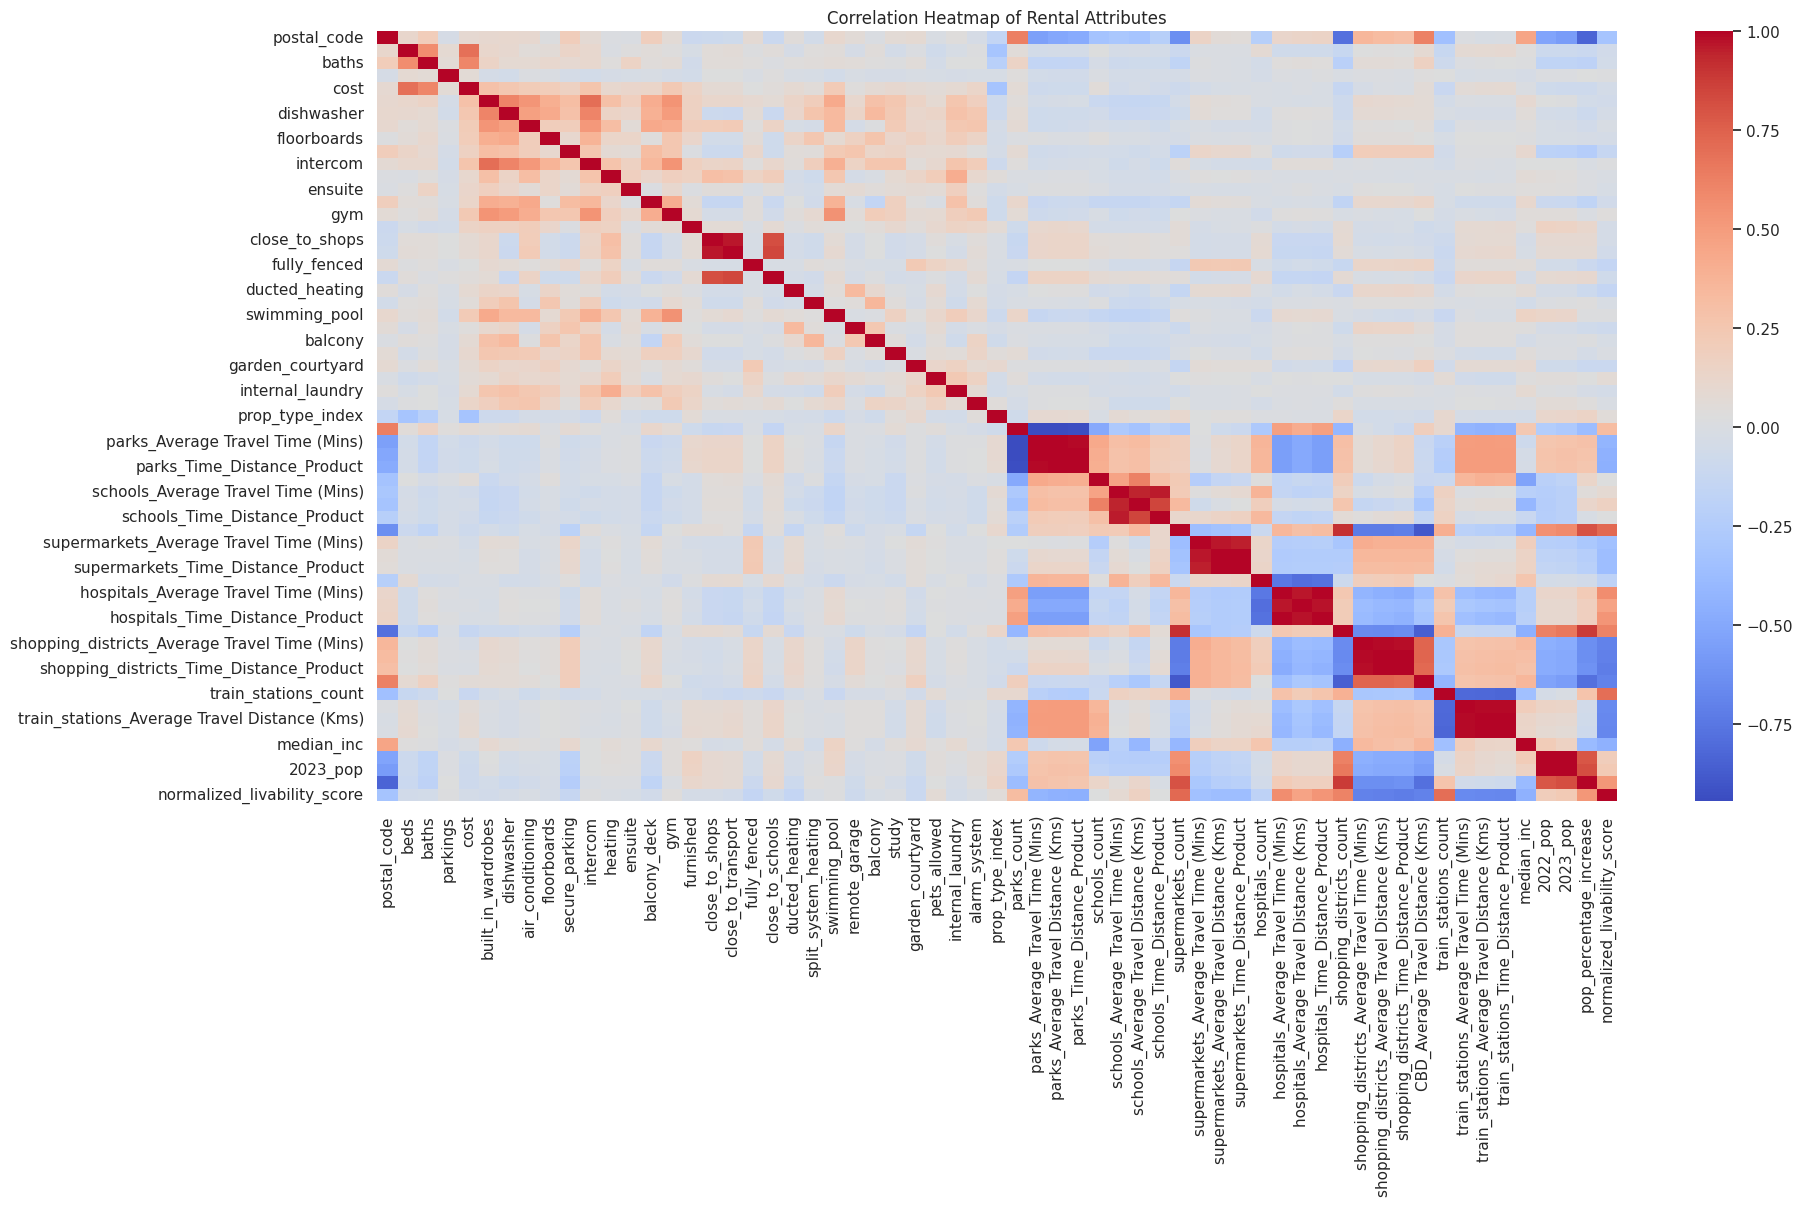

In [126]:
# Create and display the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Rental Attributes')
plt.show()

### Beds and Baths

There is a clear and strong **positive correlation** between the number of beds and baths. This is expected in residential properties, where more bedrooms typically correlate with additional bathrooms. This relationship could be useful in predicting rental prices, as properties with more amenities generally command higher rents.

The strong correlations (like that between beds and baths) should be monitored when used in regression models. High multicollinearity can inflate standard errors, making it difficult to ascertain the individual effect of each feature.

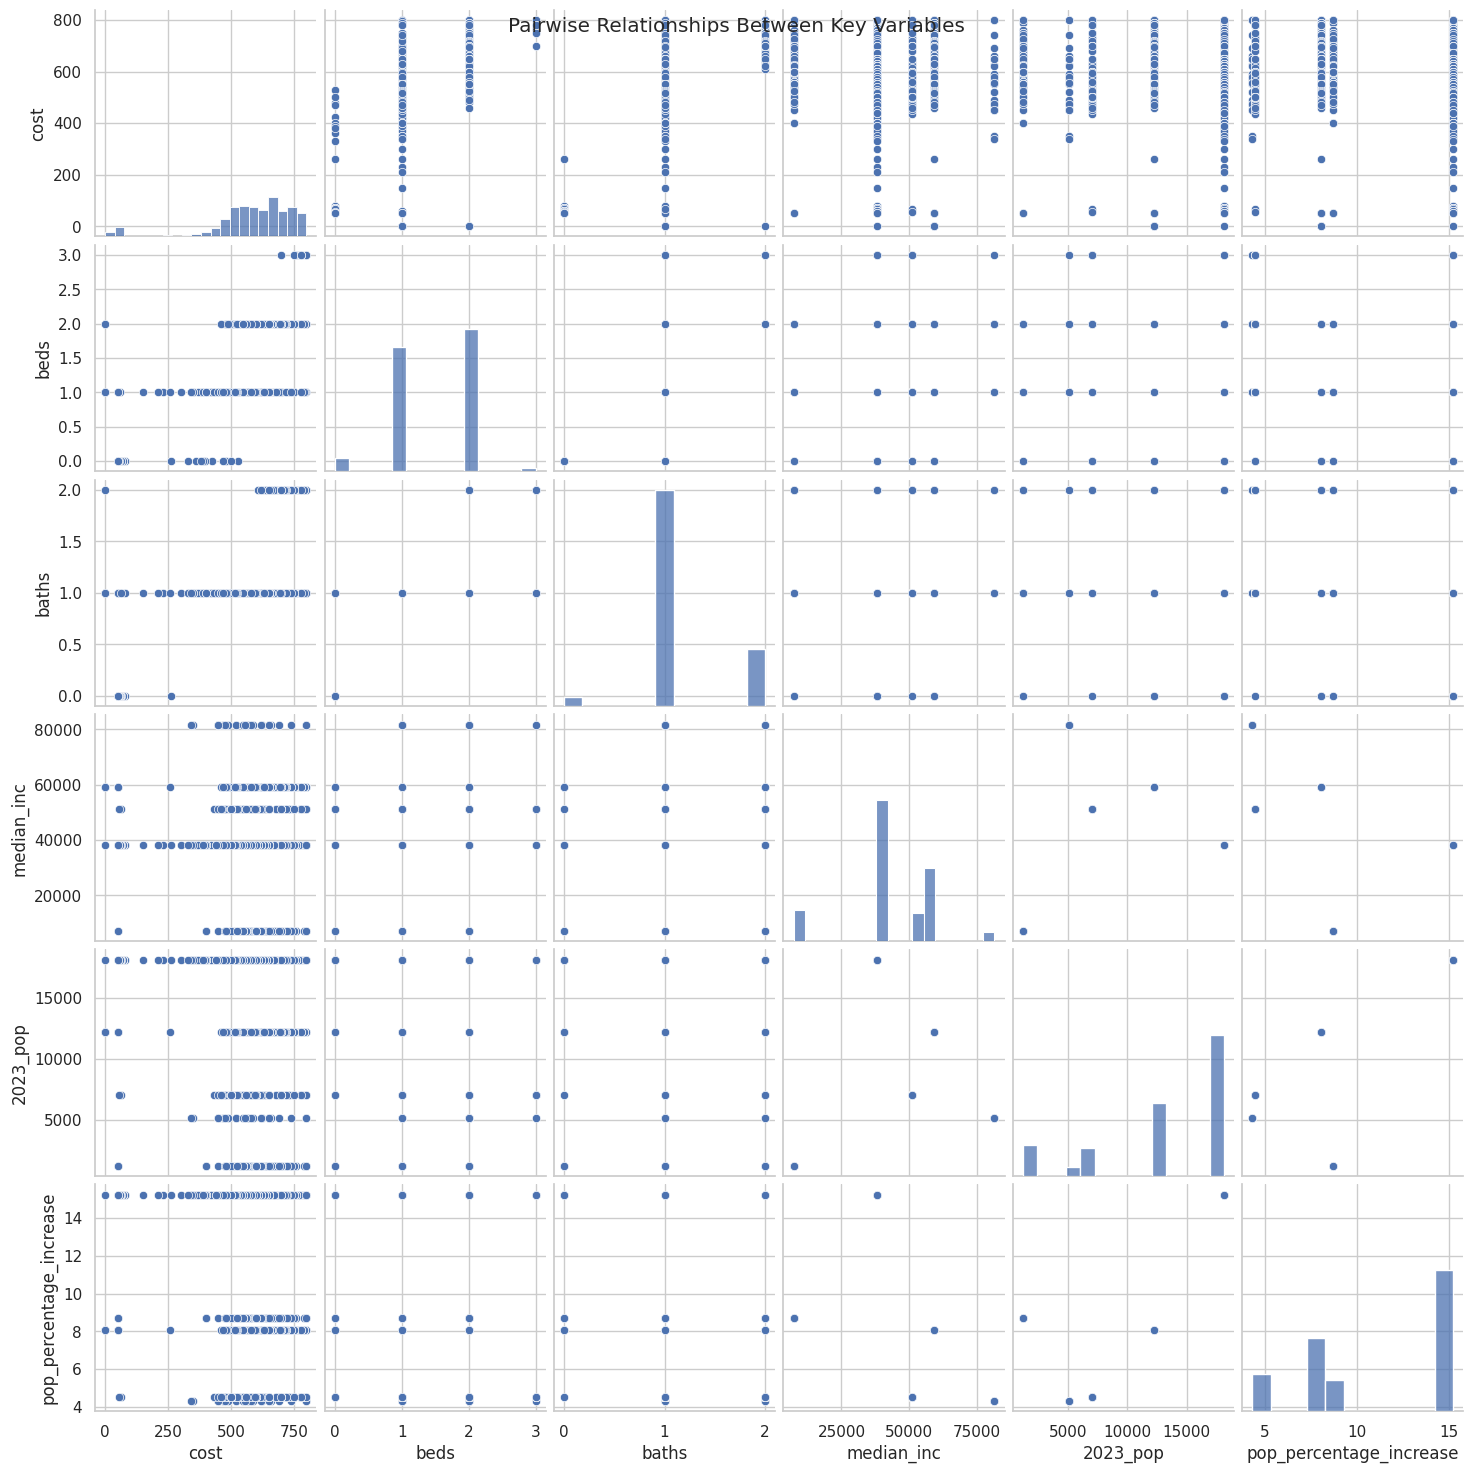

In [127]:
# Selecting a subset of relevant variables
selected_columns = df_prop[['cost', 'beds', 'baths', 'median_inc', '2023_pop', 'pop_percentage_increase']]
                            #  'parkings', 'schools', 'supermarkets', 'CBD']]
sns.pairplot(selected_columns)
plt.suptitle('Pairwise Relationships Between Key Variables')
plt.show()